In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# 4-4 SVM(Support Vector Machine)

## 0. 데이터셋 소개

### Gene expression

[유전자 발현](https://www.kaggle.com/datasets/crawford/gene-expression) microarray라는 측정 방법을 사용하여, 급성 골수성 백혈병 환자와 급성 림프구성 백혈병환자를 대상으로 유전자 발현도를 측정한 데이셋입니다.

해당 데이터는 총 7131개의 컬럼과 72개의 행을 가진 데이터로, 표본의 수보다 속성의 수가 훨씬 많은 데이터셋입니다.

주요 변수 설명

|Name|Description|
|----|---------|
|patient|patient no|
|cancer|AML: acute myeloid leukemia<br/>ALL:acute lymphoblastic leukemia|
|train|학습 데이터 여부|

그외 변수는 유전자의 발현도를 정수로 나타낸 변수들 입니다.

In [2]:
df_gene = pd.read_csv('data/gene.csv', index_col='patient')
df_gene.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer,train
patient,,,,,,,,,,,,,,,,,,,,,
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,ALL,True
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,ALL,True
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,ALL,True
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,ALL,True
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,ALL,True


## 1. 선형 판별기 (Linear Discriminant)

선형 함수의 대소 관계로 클래스를 분류하는 모델입니다.

함수 $f(x) = w^Tx + b$ 

> 양의 클래스: $f(x) \ge 0$, 
>
> 음의 클래스: $f(x) \lt 0$

로 분류를 합니다.

In [3]:
df_toy = pd.DataFrame({
    'x1': [1.5, 2.5, 2, 3, 1, 4, 2, 3, 3.4, 2.5],
    'x2': [2, 4.2, 2, 4, 1, 2, 0, 0.8, 0.5, 1],
    'Class': [1, 1, 1, 1, 1, -1, -1, -1, -1, -1]
})

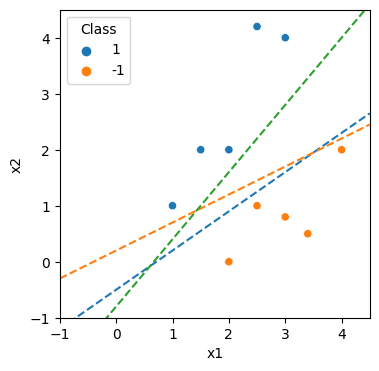

In [4]:
plt.figure(figsize=(4, 4))
sns.scatterplot(
    data=df_toy.assign(Class=lambda x: x['Class'].astype(str)), x='x1', y ='x2', hue='Class'
)
plt.gca().set_xlim(-1, 4.5)
plt.gca().set_ylim(-1, 4.5)
x1_range = np.array([-1, 4.5])
for i in [[0.7, -0.5], [0.5, 0.2], [1.2, -0.8]]:
    plt.plot(x1_range, i[0] * x1_range + i[1], linestyle='dashed')

plt.show()

## 2. 최대 마진 분류기 (Maximal margin classifier)

위와 같이 선형판별기로 분류할 수 있을 경우에 완벽히 Positive Class와 Negative Class를 구분할 수 있는 분류기는 많이 있습니다.

이 중에서 두 클래스와의 거리를 최대로 하는 분류 평면은 오분류를 최대한 줄일 수 있을 것이라는 아이디어에서 시작합니다.


### 최대 마진 분류기의 학습



선형 판별 함수

> $f(x) = w^Tx + b$

일 때, 

> 양의 클래스: $f(x) \ge 0$, 
>
> 음의 클래스: $f(x) \lt 0$

데이터의 수가 입력 변수의 수보다 많고, 완전히 분류가 가능하다고 가정합니다.

최대 마진 분류기를 찾는 과정을 구체화하기 위해,

최대 마진 분류기의 최대 마진을 확보함으로써 얻어지는 분류 영역을 아래와 같이 고정합니다.

> 양의 클래스: $f(x) \ge 1$, 
>
> 음의 클래스: $f(x) \lt -1$

분류 기준에서의 마진을 **분류 마진**이라 정의합니다.

위와 같이 분류 마진을 1로 한 것은, 학습 과정을 정의하는 데 간편함을 부여하기 위함입니다. 

고정된 분류 마진에서, 최대 마진 분류기는 **기하학적 마진**을 최대화하는 선형 분류기를  의미합니다.

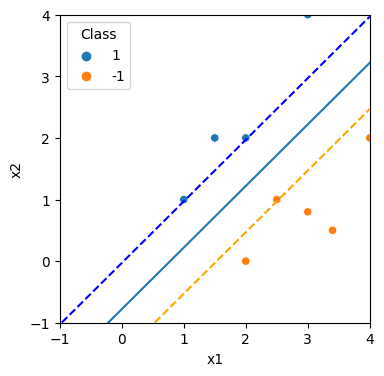

In [5]:
plt.figure(figsize=(4, 4))
plt.gca().set_xlim(-1, 4)
plt.gca().set_ylim(-1, 4)
sns.scatterplot(
    data=df_toy.assign(Class=lambda x: x['Class'].astype(str)), x='x1', y ='x2', hue='Class'
)
x1_range = np.array([-11, 4])

plt.plot(x1_range, 1 * x1_range - 0.78)
plt.plot(x1_range, 1 * x1_range - 0.78 + 0.75, linestyle='dashed', color='blue')
plt.plot(x1_range, 1 * x1_range - 0.78 - 0.75, linestyle='dashed', color='orange')

plt.show()

분류 마진을 1로 고정한 상태에서 **기하학적 마진은**

> $\frac{2}{||w||_2}$

입니다.

------------------------
[유도 과정]


$x^+$와 $x^-$는 두 평면 $w^Tx + b - 1 = 0$와 $w^Tx + b + 1 = 0$ 위의 최단 거리 상의 직선을 지나는 점이라 하면,

$w^Tx^+ + b - 1 = 0$, $w^Tx^- + b + 1 = 0$ 입니다.

$w$는 두 평면에 수직하는 벡터이고 $x^+$와 $x^-$ 는 동일 벡터상에 있으므로,

$x^+ = x^- + \lambda w$ 입니다. $\lambda$

> $distance(x^+, x^-) = ||x^+ - x^-||_2$
>
> $= ||x^- +\lambda w - x^-||_2 = ||\lambda w||_2$ --- (1)

두 직선의 방정식을 활용하면,

> $w^T(x^- + \lambda w) + b - 1 = 0$
>
> $w^Tx^- + b - 1  + \lambda w^Tw = 0$
>
> $-2 + \lambda w^Tw = 0$
>
> $\lambda = \frac{2}{w^Tw}$ --- (2)

(1), (2)를 결합하면

> $distance(x^+, x^-) = \frac{2}{||w||_2}$

**[Ex.1]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

기하학적 마진을 구하는 공식을 이용하여 두 결정 경계에 있는 임의의 점 $x^+, x^-$을 도식화 해봅니다.

```
w, b = np.array([-1.3333, 1.3333]), -0.75
```

입니다.
    
</div>

In [6]:
w, b = np.array([-1.3333, 1.3333]), -0.75
x_minus = np.array([1, -0.5])
lam = 2 / np.dot(w.T, w) # (2)번 식에서 도출
x_plus = x_minus + lam * w
x_minus, x_plus, lam

(array([ 1. , -0.5]), array([0.24998125, 0.25001875]), 0.5625281260547227)

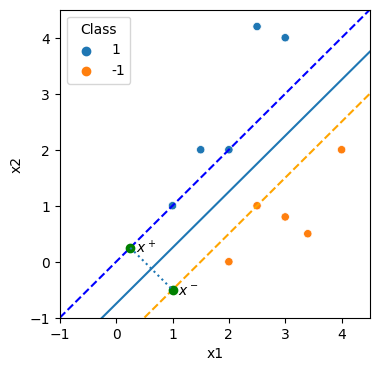

In [7]:
plt.figure(figsize=(4, 4))
plt.gca().set_xlim(-1, 4.5)
plt.gca().set_ylim(-1, 4.5)
sns.scatterplot(
    data=df_toy.assign(Class=lambda x: x['Class'].astype(str)), x='x1', y ='x2', hue='Class'
)
x1_range = np.array([-1, 4.5])

plt.plot(x1_range, 1 * x1_range - 0.75)
plt.plot(x1_range, 1 * x1_range - 0.75 + 0.75, linestyle='dashed', color='blue')
plt.plot(x1_range, 1 * x1_range - 0.75 - 0.75, linestyle='dashed', color='orange')
plt.plot(*x_minus, 'go')
plt.text(*(x_minus + np.array([0.1, -0.1])), '$x^-$')
plt.plot(*x_plus, 'go')
plt.text(*(x_plus + np.array([0.1, -0.1])), '$x^+$')
plt.gca().add_line(mlines.Line2D([x_plus[0], x_minus[0]], [x_plus[1], x_minus[1]], linestyle='dotted'))

plt.show()

따라서, 최대 마진 분류기의 학습은 


> 양의 클래스: $w^Tx + b \ge 1$, 
>
> 음의 클래스: $w^Tx + b \lt -1$ 일 때, 
>
> 기하학적 마진 $\frac{2}{||w||_2}$ 을 최대화하는 $w$를 찾는 것입니다.


이를 더 간편한 형태로 정리하면, 

> 모든 i에 대해 $y_i(w^Tx_i + b) \ge 1$ 일 때 ($y_i \in \{-1, 1\}),$
>
> $\frac{1}{2}||w||_2^2$ 를 최소화

여기서, 

> 양의 클래스: $w^Tx + b \ge 1$, 
>
> 음의 클래스: $w^Tx + b \lt -1$

위에 있는 점, 즉 결정 경계면 위에 있는 점을 **Support Vector** 라고 합니다.

-----------------------------

### Lagrange function & Lagrange Primal/Dual

양의 클래스: $w^Tx + b \ge 1$, 

음의 클래스: $w^Tx + b \lt -1$

위 조건들을 충족시면서 $\frac{1}{2}||w||_2^2$ 최소점을 찾는 것은 어렵습니다. 

w의 최적점은 목적 함수에 의해 정해지는 결정되는 게 아니라 조건에 의해 결정됩니다. 

조건들에서 w를 도출하기 위한 방향성을 직접 추출하기가 어렵기 때문입니다.

문제를 풀 수 있는 형태, 즉 조건에서 w의 방향성을 구할 수 있는 형태, 바꾸어 가기 위해 사용된 개념이 Lagrange Primal / Dual 입니다.

#### Lagrange Primal

부등식 제약 조건이 있는 최적화 문제를 부등식 제약을 목적함수에 포함시키는 방식으로 문제로 바꿉니다. 

> $f_t(\theta)\ge0, i = 1,... n$ 일 때,
>
> $J(\theta)$를 최소화 

Lagrange function을 $\theta$에 대해서는 최소화하고, $\alpha_i$에 대해서는 최대화하는 문제로 바꾸어,

최적화 과정에서 제약 조건이 충족되도록 형태를 바꿉니다.

> $L(\theta, \alpha)=J(\theta) - \sum_{i=1}^n\alpha_i f_t(\theta)$ : **Lagrange function**
>
> $max_{\alpha} \left(min_{\theta} L(\theta, \alpha)\right)$
>
> Lagrange multiplier: $\alpha_i$, $\alpha_i \ge 0$, i=1,...,n

이러한 형태의 문제를 Lagrangian Primal 이라고 합니다.

#### Lagrange Dual

최소화와 최대화 동시에 두 개의 최적화 과정이 있으므로, 이 또한 어렵습니다.

아래의 KKT(Karush-Kuhn-Tucker) 조건을 충족시키면, 

$\theta$에 대한 최소화 요건은 $\alpha_i$에 대한 최대화 문제로 바꿀 수 있습니다.(Lagrangian Dual)

> (1) $\frac{\partial{L(\theta, \alpha)}}{\partial\theta}=0$
>
> (2) $f_t(\theta) \ge 0, i=1, ... n$
>
> (3) $\alpha_i \ge 0, i=1, ... n$
>
> (4) $\alpha_if_t(\theta) = 0, i=1, ... n$

(1) (2) (3) (4) 만족한다면,

> $max_{\alpha} \left(L(\theta, \alpha)\right)$


------------------------------------
최대 마진 분류기의 최적화 요건은 아래와 같습니다.

> 모든 i에 대해 $y_i(w^Tx_i + b) \ge 1$ 일 때, ($y_i \in \{-1, 1\}),$  
>
> $\frac{1}{2}||w||_2^2$ 를 최소화

Langrangian Primal 형태로 변환, 


> $L(w, b, \alpha) = \frac{1}{2}||w||_2^2 - \sum_{i=1}^n\alpha_i\left(y_i(w^Tx_i + b) - 1\right)$
>
> $max_{\alpha}min_{w, b}\left(L(w, b, \alpha)\right)$
>
> $\alpha_i \ge 0$, i=1,...,n

Langrangian Dual를 적용합니다.

이를 위해서는 KKT 조건을 만족해야 합니다.

KKT 조건은

> $\frac{\partial{L(w, b, \alpha)}}{\partial{w}} = 0$ --- (5)
>
> $\frac{\partial{L(w, b, \alpha)}}{\partial{b}} = 0$ --- (6)
>
> $y_i(w^Tx_i + b) - 1 \ge 0, i=1, ... n$ --- (7)
>
> $\alpha_i \ge 0, i=1, ... n$ --- (8)
>
> $\alpha_i\left(y_i(w^Tx_i + b) - 1\right) = 0, i=1, ... n$ --- (9)


(5)는 $L(w, b, \alpha)$이 $w$에 대해서는 Convex 문제이기 때문에 $w$에 대해서 최적점이기도 합니다.


(5)를 풀면, 

> $w - \sum_{i=1}^n\alpha_iy_ix_i = 0$
>
> $w = \sum_{i=1}^n\alpha_iy_ix_i$ ---(8)

(6)을 풀면, 

> $\sum_{i=1}^n\alpha_iy_i = 0$ ---(9)

$L(w, b, \alpha)$에 (8)을 적용합니다.

> $L(w, b, \alpha) = \frac{1}{2}||w||_2^2 - \sum_{i=1}^n\alpha_i\left(y_i(w^Tx_i + b) - 1\right)$
>
> $L(w, b, \alpha) = \frac{1}{2}\left(\sum_{i=1}^n\alpha_iy_ix_i\right)^T\left(\sum_{j=1}^n\alpha_jy_jx_j\right) - \sum_{i=1}^n\alpha_i\left(y_i(\left(\sum_{j=1}^n\alpha_jy_jx_j\right)^Tx_i + b) - 1\right)$
>
> $ = \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n\alpha_i\alpha_jy_iy_jx_j^Tx_i - \sum_{i=1}^n\sum_{j=1}^n\alpha_i\alpha_jy_iy_jx_j^Tx_i - \sum_{i=1}^n\left(\alpha_iy_ib - \alpha_i\right)$
>
> $ = -\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n\alpha_i\alpha_jy_iy_jx_j^Tx_i - \sum_{i=1}^n\left(\alpha_iy_ib - \alpha_i\right)$

(9)를 적용합니다.

> $ = \sum_{i=1}^n\alpha_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n\alpha_i\alpha_jy_iy_jx_i^Tx_j$


이로써 SVM의 학습은 아래에서 최적의 $\alpha_i, i = 1, ... n$를 구하는 문제로 정리됩니다.

> $L(\alpha) = max_{\alpha} \left(\sum_{i=1}^n\alpha_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n\alpha_i\alpha_jy_iy_jx_i^Tx_j\right)$

where, 

> $\sum_{i=1}^n\alpha_iy_i = 0 \ldots(9)$
>
> $w = \sum_{i=1}^n\alpha_iy_ix_i \ldots(8)$
>
> $y_i(w^Tx_i + b) - 1 \ge 0, i=1, ... n \ldots(7)$
>
> $\alpha_i \ge 0, i=1, ... n \ldots(3)$
>
> $\alpha_i\left(y_i(w^Tx_i + b) - 1\right) = 0, i=1, ... n \ldots(4)$

KKT의 조건을 고찰하면, $\alpha_i$ 또는 $y_i(w^Tx_i + b) - 1$ 둘 중의 하나는 반드시 0이어야 합니다.

$\alpha$**는 Support Vector 여부를 나타냅니다.**

$\alpha_i = 0$이면, $y_i(w^Tx_i + b) - 1 > 0$ 이라도 (4)를 만족시켜 KKT 조건에 어긋나지 않습니다.

$y_i(w^Tx_i + b) - 1 = 0$ 일 경우는 $\alpha_i > 0$이라도 (4)를 만족시켜 KKT 조건에 어긋나지 않습니다.

다시 말해 $\alpha_i > 0$ 이면, 확실히 i는 결정 경계에 있는 점이고 즉 **Support Vector**인 것입니다.

---------------------------------------------------

최대 마진 분류기의 학습은 선형으로 분리가 가능한 분류 데이터셋에 대해서만 가능합니다.

이러한 한계점을 극복하기 위해 두 가지 접근법을 사용합니다.

1. 분리가 가능하지 않는 데이터에서도 적용할 수 있도록 다음 분리 조건에 대한 완화

> 모든 i에 대해 $y_i(w^Tx_i + b) \ge 1$ 일 때 ($y_i \in \{-1, 1\}),$ 

2. 분리가 되도록 데이터를 변형하는 방법

첫 번째 접근법이 **소프트 마진 분류기**이고, 두 번째 접근법이 **커널 함수**를 통한 고차원 벡터로 변환하는 방법입니다.

## 3. 소프트 마진 분류기

최대 마진 분류기에서 아래와 같이 

> 모든 i에 대해 $y_i(w^Tx_i + b) - 1 + \xi_i \ge 0$ 일 때, ($y_i \in \{-1, 1\}),$  
>
> 모든 i에 대해 $\xi_i \ge 0$
>
> $\frac{1}{2}||w||_2^2 + C\sum_{i=1}^n\xi_i$를 최소화

Langrangian Primal은


> $L(w, b, \xi, \alpha, \gamma) = \frac{1}{2}||w||_2^2 + C\sum_{i=1}^n\xi_i - \sum_{i=1}^n\alpha_i\left(y_i(w^Tx_i + b) - 1 + \xi_i\right) - \sum_{i=1}^n\gamma_i\xi_i$
>
> $max_{\alpha, \gamma}min_{w, b, \xi}\left(L(w, b, \xi, \alpha, \gamma)\right)$
>
> $\alpha_i \ge 0$, i=1,...,n, $\gamma_i \ge 0$, i=1,...,n

Langrangian Dual를 적용합니다.

KKT 조건은

> $\frac{\partial{L(w, b, \xi, \alpha, \gamma)}}{\partial{w}} = 0$
>
> $\frac{\partial{L(w, b, \xi, \alpha, \gamma)}}{\partial{b}} = 0$
>
> $\frac{\partial{L(w, b, \xi, \alpha, \gamma)}}{\partial{\xi_i}} = 0$ --- (10)
>
> $y_i(w^Tx_i + b) - 1 + \xi_i \ge 0, i=1, ... n$
>
> $w = \sum_{i=1}^n\alpha_iy_ix_i$
>
> $\alpha_i \ge 0, i=1, ... n$
>
> $\alpha_i\left(y_i(w^Tx_i + b) - 1 + \xi_i \right) = 0, i=1, ... n$
>
> $\gamma_𝑖\xi_𝑖 = 0, i=1, ... n$

(10)에서  $\alpha_i = C - \gamma_i$ 가 유도됩니다.

$\gamma_𝑖\xi_𝑖 = 0, i=1, ... n$ 에서, 

무조건  $\gamma_i = 0$으로 할 수 있지만, $\alpha_i$ 가 작을 수록 기하학적 마진이 크므로,

보다 작은 기하학적 마진을 갖게 하기 위해, 되도록 이면 $\gamma_i$가 큰 값을 지니도록 합니다.

그래서, $\xi_i = 0$이면 $\gamma_i > 0$이 되고, $\xi_i \gt 0$ 이면  $\gamma_i = 0$ 가 되도록 합니다.

이렇게 최적화한 방법으로 SVM을 학습을 하게 되면,

> $\alpha_i = 0$ 이면 $\gamma_i = C, \xi_i = 0$ 인 최대 마진 바깥 쪽의 데이터
>
> $0 < \alpha_i < C$ 이면 $\gamma_i > 0, \xi_i = 0$ 인 최대 마진 위의 점인 **Support Vector**
>
> $\alpha_i = C$ 이면 $\gamma_i = 0, \xi_i > 0$ 인 최대 마진 안 쪽에 점인 **Support Vector**

이 되게 됩니다.

이로써 SVM의 학습은 최적의 $\alpha_i, i = 1, ... n$를 구하는 문제가 됩니다.

> $L(\alpha) = max_{\alpha} \left(\sum_{i=1}^n\alpha_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n\alpha_i\alpha_jy_iy_jx_i^Tx_j\right)$

where, 

> $\sum_{i=1}^n\alpha_iy_i = 0$
>
> $w = \sum_{i=1}^n\alpha_iy_ix_i$
>
> $y_i(w^Tx_i + b) - 1 + \xi_i \ge 0, i=1, ... n$
>
> $0 \le \alpha_i \le C , i=1, ... n$
>
> $\alpha_i\left(y_i(w^Tx_i + b) - 1 + \xi_i\right) = 0, i=1, ... n$

- 소프트 마진 분류기에서의 Support Vector

최대 마진 분류기에서는 결정 경계면 위의 데이터 포인트들이 **Support Vector**가 되지만,

소프트 마진 분류기에서는 **Support Vector**는 결정면을 구성하는 데이터 포인트이고, 결정 경계면의 안쪽의 데이터 포인트 입니다.


**▷ 일반적으로 두 클래스의 결정면을 결정하는 데이터 포인트를 Support Vector라고 합니다.**

## 4. 커널(Kernel)

데이터를 고차원 공간으로 매핑하여 선형 분리 가능한 상태로 변환하는 함수입니다.

예) $x_1, x_2$ → $x_1, x_2, x_1x_2, x_1^2, x_1^2$

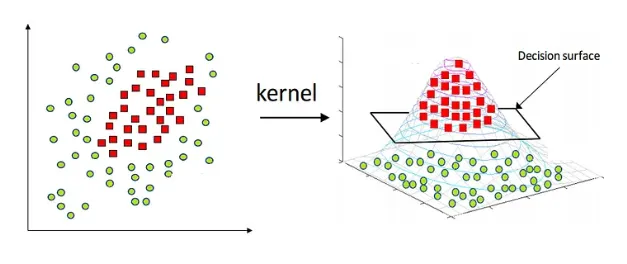

※이미지 출처: https://medium.com/@Suraj_Yadav/what-is-kernel-trick-in-svm-interview-questions-related-to-kernel-trick-97674401c48d

이러한 고차원 공간의 매핑은 변수의 수가 많아질 수록, 파생되는 변수의 수는 훨씬 많아집니다. 이에 대응하기 위해 커널 트릭(kernel trick)이 사용됩니다. 이를 이용하면 직접 고차원 매핑 변수를 만들지 않아도 커널을 적용할 수 있습니다.

#### 커널 트릭(Kernel trick)

학습과 예측에 필요한 것은 입력 데이터 전체가 아니라 입력 데이터의 내적($x_i^Tx_i$) 입니다.

- 학습시,

> $L(\alpha) = max_{\alpha} \left(\sum_{i=1}^n\alpha_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n\alpha_i\alpha_jy_iy_jx_i^Tx_j\right)$


- 예측시, 

> $w = \sum_{i=1}^n\alpha_iy_ix_i$ 
>
> $f(x) = w^Tx + b$ 
>
> → $ f(x) = \sum_{i=1}^n\alpha_iy_ix_i^Tx + b$

이점에 착안하여, 내적하기 전에 고차원 매핑 변수를 만드는게 아니라, 

내적한 값에 Kernel 함수를 적용하여 고차원 매핑효과를 얻는 것을 이용합니다.


가령,

$\mathbf{a} = \begin{bmatrix} a_0 \\ a_1 \\ \vdots \\ a_n \end{bmatrix}$, $\mathbf{b} = \begin{bmatrix} b_0 \\ b_1 \\ \vdots \\ b_n \end{bmatrix}$

$a^Tb = (a_0b_0 + a_1b_1 + ... + a_nb_n)$ 입니다. 

$\phi(x)$를 2차 동차 다항 변환이라면,

$\mathbf{\phi(a)} = \begin{bmatrix} a_0^2 \\ a_0a_1 \\ \vdots \\ a_n^2 \end{bmatrix}$, $\mathbf{\phi(b)} = \begin{bmatrix} b_0^2 \\ b_0b_1 \\ \vdots \\ b_n^2 \end{bmatrix}$

$\phi(a)^T\phi(b) = (a_0^2b_0^2 + a_0a_1b_0b_1 + ... a_n^2b_n^2)$

$\left(a^Tb\right)^2 = (a_0b_0 + a_1b_1 + ... + a_nb_n)(a_0b_0 + a_1b_1 + ... + a_nb_n) = a_0^2b_0^2 + 2a_0a_1b_0b_1 + ... + a_n^2b_n^2$ 

즉, $\phi(x_i^T)phi(x_i)$ → $\phi'(x_i^Tx_i)$ 동일한 효과를 얻을 수 있는 고차항 매핑을 구성할 수 있습니다.


#### 커널(Kernel)의 종류 및 특징

|커널명|커널 함수|특징|
|----:|:---:|:----|
|선형 커널(Linear kernel)|$$x_i \cdot x_j$$|SVM 모델은 선형의 결정 함수로 나타낼 수 있습니다.|
|동차 다항 커널(Homogeneous polynomial kernel)|$$\left(x_i \cdot x_j\right)^d$$|모든 항의 차수가 d인 다항 변환이 됩니다.|
|비동차 다항 커널(Inhomogeneous polynomial kernel)|$$\left(x_i \cdot x_j + r\right)^d$$|항의 차수가 d보다 작은 다항 변환이 됩니다.|
|가우시안 방사 기저 함수 커널(Gaussian Radial Base Function kernel)|$$exp^{-\gamma||x_i - x_j||^2}, \gamma > 0, 주로 \gamma=1/(2\sigma^2) $$<br> $\gamma$가 클 수록 복잡한 경계면이 생깁니다. 모델의 편향이 낮아 집니다|무한 차수의 다항 커널의 합과 같은 형태의 변환이 됩니다.|
|시그모이드 함수 커널(Sigmoid function kernel)|$$tanh(\kappa x_i \cdot x_j + c), \kappa > 0, c < 0$$||


#### 커널 함수의 기본 요건

1. 커널 행렬은 양의 준정부호(positive semidefinite, 모든 벡터 z에 대해 $z^TKz \ge 0$)이어야 합니다.


2. Mercer의 정리(Merger's theorem): 커널 함수 K(x, y) 는 다음과 같은 수식을 만족합니다.

> $\int_{X \times X} |K(x, y)|^2 \, d\mu(x) \, d\mu(y) < \infty$


## 5. SVM(Support Vector Machine)

소프트 마진 분류기(Soft Margin Classifier) + 커널(Kernel)의 두 개념이 합쳐진 머신 러닝 모델입니다.

### 모델의 구성

선형 커널 사용 여부에 따라 모델의 성격이 달라 집니다.

- 선형 커널 SVM은 w와 절편(b)로 구성 됩니다.

> 모수적 모델이 됩니다.

- 비선형 커널은 Support Vector, 커널 함수 그리고 절편(b)으로 모델이 구성 됩니다.

> K-최근접 이웃 처럼 데이터 포인트를 모델에 지니게 됩니다. SVM은 전체 데이터가 아니라 Support Vector만을 지니고 있게 됩니다.

### 학습

> $L(\alpha) = max_{\alpha} \left(\sum_{i=1}^n\alpha_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n\alpha_i\alpha_jy_iy_j\phi(x_i^Tx_j)\right)$

where, 

> $\sum_{i=1}^n\alpha_iy_i = 0$
>
> $w = \sum_{i=1}^n\alpha_iy_ix_i$
>
> $y_i(w^Tx_i + b) - 1 + \xi_i \ge 0, i=1, ... n$
>
> $0 \le \alpha_i \le C , i=1, ... n$
>
> $\alpha_i\left(y_i(w^Tx_i + b) - 1 + \xi_i\right) = 0, i=1, ... n$

최적의 $\alpha_i, i = 1, ... n$를 구하는 것입니다.

초기에는 $\frac{\partial{L(\alpha)}}{\alpha}$를 구할 수 있어 $\alpha$에 대한 경사하강법으로 접근을 했었지만, KKT 요건을 충족시키면서 최적의 $\alpha$를 만들기에는 경사하강법은 쉽지 않았습니다.

이러한 한계점에 대응하여 나온 방법이 [SMO, Sequential Minimal Optimization](https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines) 알고리즘 입니다.

Key-Idea는 다음과 같습니다. 

두 개의 데이터 포인트, $x_i, x_j$의 KKT 조건을 만족시키는 최적의 $\alpha_i, \alpha_j$를 구하는 것은 닫힌 형태의 해가 존재합니다.

KKT 조건에 가장 크게 어긋 나는 데이터 포인트를 $x_i, x_j$를 찾아내어 $\alpha_i, \alpha_j$를 업데이트합니다.

이 과정을 $\alpha_i, \alpha_j$가 수렴할 때까지 반복합니다.

**※주의!!※**

SVM은 입력 데이터의 스케일이 균일하지 않으면, 수렴하는데 굉장히 오래 걸릴 수 있습니다. 다른 알고리즘에 비해 학습시간이 너무나 오래 걸린다면, 입력 데이터의 스케일이 고른지 확인하고, 그렇지 않다면  표준화 또는 정규화를 해줍니다.

### 분류

판별함수 f(x)에 대해

> 양의 클래스: $f(x) \ge 0$, 
>
> 음의 클래스: $f(x) \lt 0$

으로 결정합니다.

판별 함수는 아래와 같습니다.

- Linear Support Vector Machine


함수 $f(x) = w^Tx + b$ 

> $w = \sum_{i=1}^n\alpha_iy_ix_i$

- Kernel Support Vector Machine

커널 트릭을 이용한다면, 판별 함수는

> $f(x) = \sum_{i=1}^n\alpha_iy_i\phi(x_i, x)$

가 됩니다.


Support Vector가 아닌 데이터 포인트들은 $\alpha_i = 0$ 이므로 결정면은 $\alpha_i > 0$인 Support Vector들을 통해서도 유도를 할 수 있습니다.

Linear Support Vector Machine의 w는 

> $w = \sum_{i \in \text{Index of Support Vectors} }^n\alpha_iy_ix_i$

이고 Kernel Support Vector Machine 은

> $f(x) = \sum_{i \in \text{Index of Support Vectors} }\alpha_iy_i\phi(x_i, x)$

가 됩니다.


-----

**sklearn.svm.SVC**, **sklearn.svm.SVR**

**sklearn.svm.LinearSVC**, **sklearn.svm.LinearSVR**


**sklearn.svm.SVC**, **sklearn.svm.SVR** 의 커널 파라메터

|커널명|커널 함수|kernel|kernel 하이퍼 파라메터|
|----:|:---:|:----|----|
|선형 커널(Linear kernel)|$$x_i \cdot x_j$$|linear||
|다항 커널(polynomial kernel)|$$(\gamma x_i \cdot x_j + r)^d$$|poly|$\gamma$: gamma, $d$: degree, $r$: coef0|
|가우시안 방사 기저 함수 커널(Gaussian Radial Base Function kernel)|$$exp^{-\gamma||x_i - x_j||^2}$$|rbf|$\gamma$: gamma|
|시그모이드 함수 커널(Sigmoid function kernel)|$$tanh(\gamma x_i \cdot x_j + r)$$|sigmoid|$\gamma$: gamma, $r$: coef0|

**[Ex.2]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_toy를 선형커널을 사용하여 Support Vector를 구해봅니다. Support Vector를 이용하여 Weight Vector를 구해봅니다.
    
</div>

In [8]:
from sklearn.svm import SVC
C = 1e5 # 선형 분리가 가능한 경우이므로 임의의 큰 수를 주었고, 최대한 분리해봅니다. 

clf_svc = SVC(C=C, kernel='linear')
clf_svc.fit(df_toy[['x1', 'x2']], df_toy['Class'])

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Weight Vector를 구하는 공식입니다.

$w = \sum_{i=1}^n\alpha_iy_ix_i$ 

In [9]:
clf_svc.support_vectors_, clf_svc.support_ # Support Vector와 Support Vector Index입니다.

(array([[2.5, 1. ],
        [2. , 2. ],
        [1. , 1. ]]),
 array([9, 2, 4]))

In [10]:
clf_svc.dual_coef_ # alpha × y 에 해당하는 값입니다.

array([[-1.7772,  1.3329,  0.4443]])

In [11]:
w = np.dot(clf_svc.dual_coef_, clf_svc.support_vectors_)
b = clf_svc.intercept_
w, b

(array([[-1.3329,  1.3329]]), array([0.99978333]))

선형 커널을 사용한 SVM의 Weight vector와 intercept_ 만으도 예측이 가능합니다. sklearn에서는 선형 커널을 사용하는 SVC를 따로 만들어 제공합니다.

In [12]:
from sklearn.svm import LinearSVC
clf_lsvc = LinearSVC(C=C)
clf_lsvc.fit(df_toy[['x1', 'x2']], df_toy['Class'])

LinearSVC(C=100000.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [13]:
clf_lsvc.coef_, clf_lsvc.intercept_

(array([[-1.33331729,  1.33338276]]), array([0.99992231]))

In [14]:
np.dot(df_toy[['x1', 'x2']], clf_lsvc.coef_[0].T) + clf_lsvc.intercept_

array([ 1.66671189,  3.26683667,  1.00005325,  2.33350147,  0.99998778,
       -1.66658134, -1.66671227, -1.93332336, -2.8666651 , -0.99998816])

In [15]:
# Decision Function은 분류 마진을 출력합니다.
clf_lsvc.decision_function(df_toy[['x1', 'x2']])

array([ 1.66671189,  3.26683667,  1.00005325,  2.33350147,  0.99998778,
       -1.66658134, -1.66671227, -1.93332336, -2.8666651 , -0.99998816])

In [16]:
clf_svc.decision_function(df_toy[['x1', 'x2']])

array([ 1.66623333,  3.26571333,  0.99978333,  2.33268333,  0.99978333,
       -1.66601667, -1.66601667, -1.93259667, -2.86562667, -0.99956667])

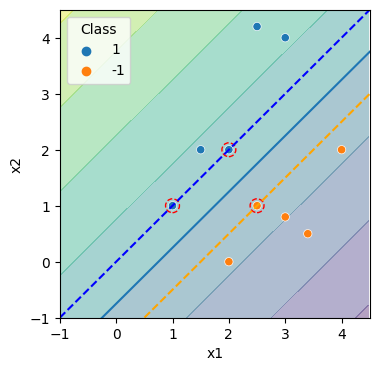

In [17]:
plt.figure(figsize=(4, 4))
plt.gca().set_xlim(-1, 4.5)
plt.gca().set_ylim(-1, 4.5)

xx, yy = np.meshgrid(np.arange(-1, 4.5, 0.02),
                     np.arange(-1, 4.5, 0.02))

# 각 점에 대한 예측값 계산
Z = clf_svc.decision_function(np.c_[xx.ravel(), yy.ravel()])

# 예측 결과를 시각화
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)

sns.scatterplot(
    data=df_toy.assign(Class=lambda x: x['Class'].astype(str)), x='x1', y ='x2', hue='Class'
)
x1_range = np.array([-1, 4.5])

plt.plot(x1_range, 1 * x1_range - 0.75)
plt.plot(x1_range, 1 * x1_range - 0.75 + 0.75, linestyle='dashed', color='blue')
plt.plot(x1_range, 1 * x1_range - 0.75 - 0.75, linestyle='dashed', color='orange')
plt.scatter(clf_svc.support_vectors_[:, 0], clf_svc.support_vectors_[:, 1], 
            s=100, color='r', facecolors='none', label='Support vectors',  linestyle='--')

plt.show()

**[Ex_3]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

아래 코드는 원형의 결정 경계면을 갖는 데이터를 만듭니다. Linear Kernel과 2차 동차 다항 커널의 분류결과를 비교해봅니다.

비교는 accuracy로 합니다.

```python
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X_circle, y_circle = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=123)
```
    
</div>

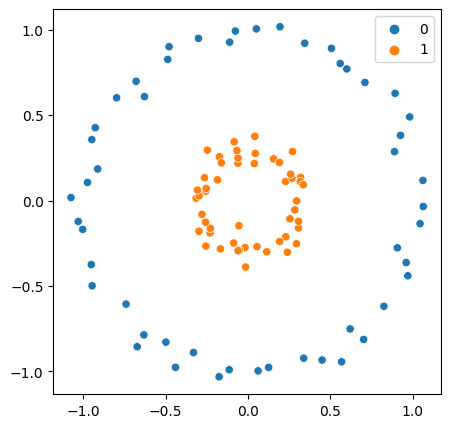

In [18]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X_circle, y_circle = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=123)

plt.figure(figsize=(5, 5))
sns.scatterplot(x = X_circle[:, 0], y=X_circle[:, 1], hue=y_circle)
plt.show()

In [19]:
from sklearn.metrics import accuracy_score

clf_lsvm = LinearSVC(C=1)
clf_lsvm.fit(X_circle, y_circle)
accuracy_score(y_circle, clf_lsvm.predict(X_circle))

0.5

In [20]:
from sklearn.metrics import accuracy_score

clf_svm = SVC(C=1, kernel='poly', degree=2, coef0=0, gamma=1)
clf_svm.fit(X_circle, y_circle)
accuracy_score(y_circle, clf_svm.predict(X_circle))

1.0

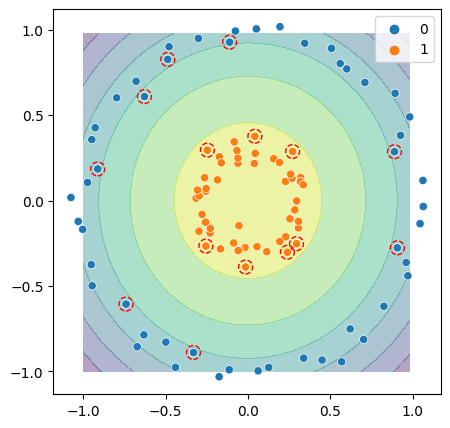

In [21]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X_circle, y_circle = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=123)

plt.figure(figsize=(5, 5))

xx, yy = np.meshgrid(np.arange(-1, 1, 0.02),
                     np.arange(-1, 1, 0.02))

# 각 점에 대한 예측값 계산
Z = clf_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])

# 예측 결과를 시각화
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)

sns.scatterplot(x = X_circle[:, 0], y=X_circle[:, 1], hue=y_circle)

plt.scatter(clf_svm.support_vectors_[:, 0], clf_svm.support_vectors_[:, 1], 
            s=100, color='r', facecolors='none', label='Support vectors',  linestyle='--')
plt.show()

**[Ex.4]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_gene를 train이 True 면 df_gene_train, False면 df_gene_test로 나눕니다.

df_gene_train에서 cancer(target)으로 입력 변수 별로 t-독립성 검정을 합니다(이분산을 가정합니다). 
    
검정 통계량의 절대값이 큰 변수를 우선적으로 1~200개 선택합니다. 선택한 개수별로 로지스틱 회귀분석과 Linear SVM의 성능을 비교해봅니다.

성능 비교는 df_gene_train으로 학습을 시키고 df_gene_test로 평가를 하여 평가셋에서의 성능을 봅니다. 

성능 지표: 정확도(Accuracy)
    
</div>

In [22]:
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind

X_all = [i for i in df_gene.columns if i != 'cancer' and i != 'train']

def get_corr(X, y):
    scores, pvalues = list(), list() 
    # 입력 변수 X의 각 변수들의 대상 변수의 값이 AML, ALL로 구분했을 때의 t 검정을 수행합니다. 이 때 등분산이 아니라고 설정합니다.
    stat, pval  = ttest_ind(X[y == 'AML'], X[y == 'ALL'], equal_var=False)
    return np.abs(stat), pval

stat, pval = get_corr(df_gene[X_all], df_gene['cancer'])

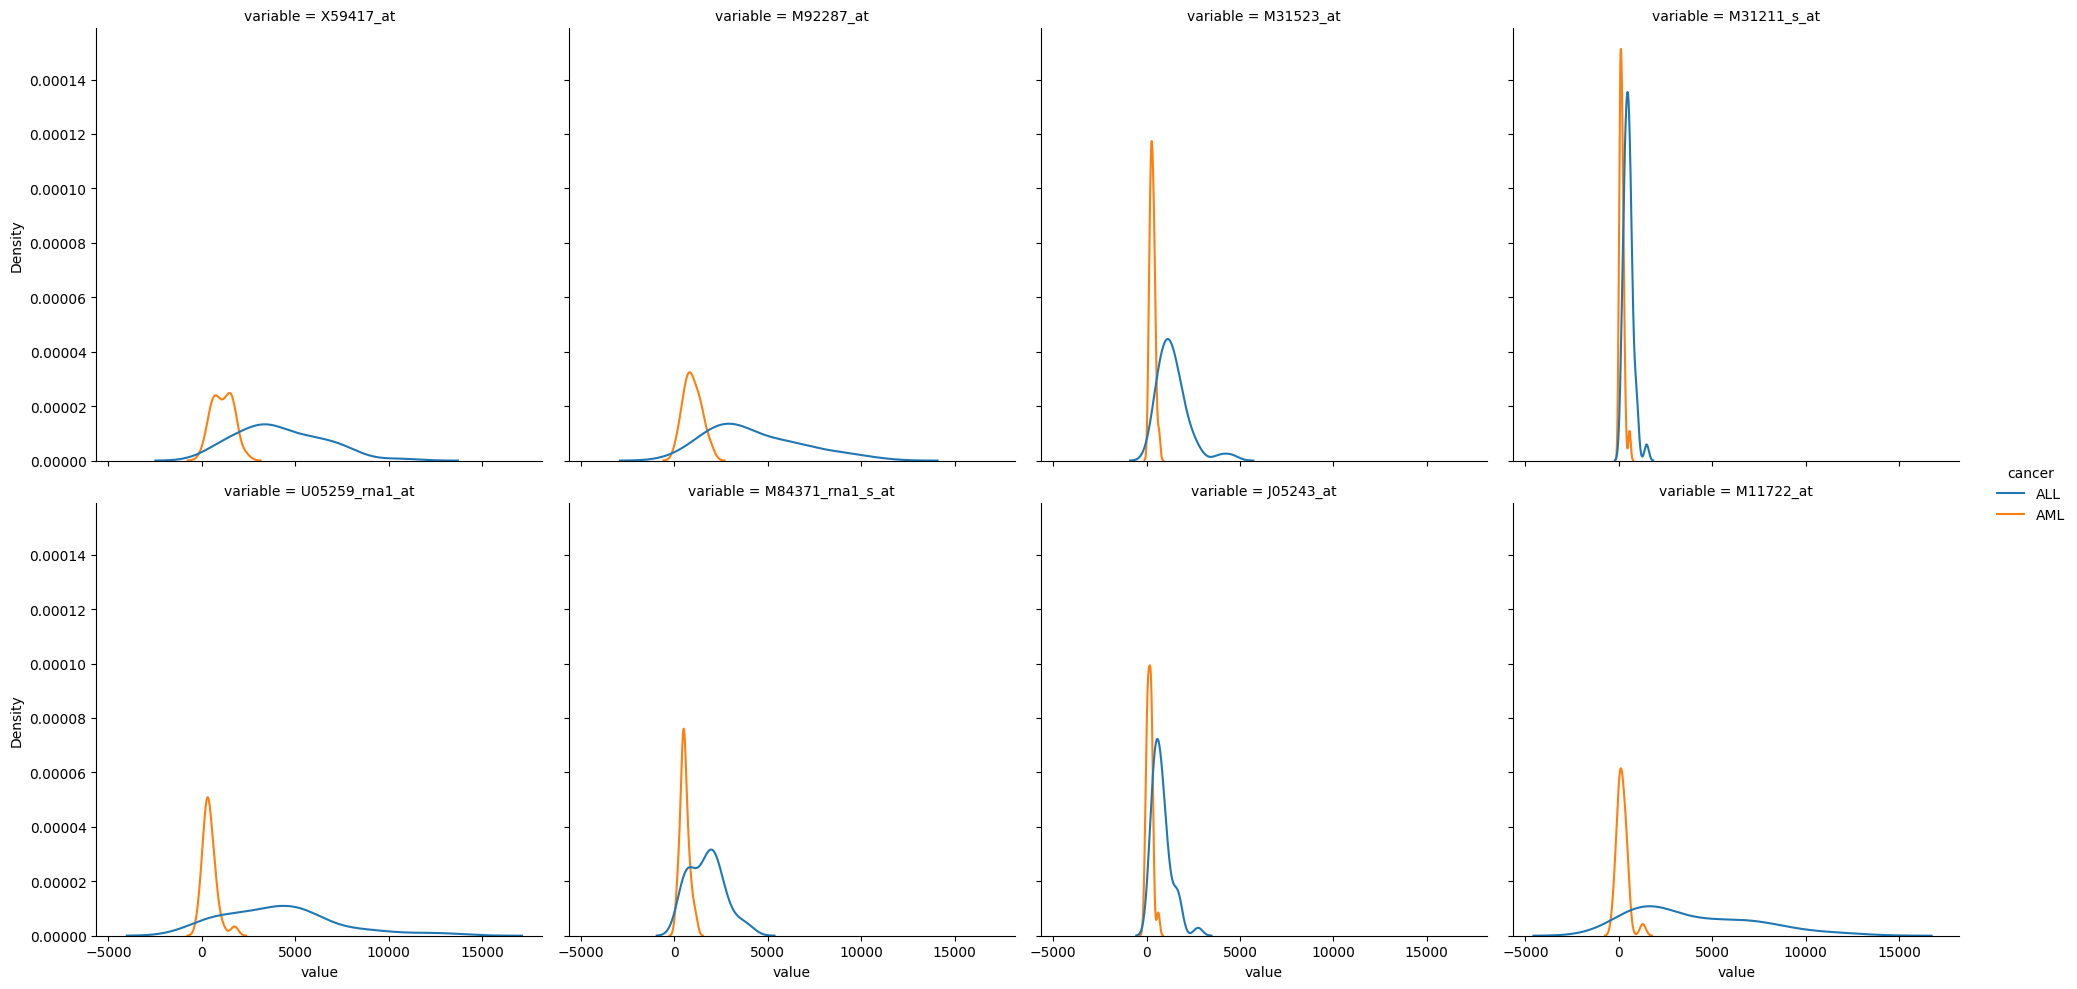

In [23]:
# t-독립성 검정의 pvalue 절대값를 기준으로 상위 8개의 변수들의 분포를 Kernel Density 차트로 시각화합니다.
sns.displot(
    data=pd.concat([df_gene.iloc[:, np.argsort(pval)[:8]], df_gene['cancer']], axis=1).melt(id_vars='cancer'), 
    x='value', col='variable', col_wrap=4, hue='cancer', kind='kde'
)
plt.show()

In [24]:
df_gene_train = df_gene.loc[df_gene['train'] == True]
df_gene_test = df_gene.loc[df_gene['train'] == False]
feat_num = np.arange(1, 201)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


lr_train_scores = list()
lr_test_scores = list()
# 선택한 변수에 수에 따른 평가 성능을 측정합니다.
for i in feat_num:
    # 1. SelectKBest  처리기를 통해 t검정의 pvalue  절대값을 기준으로 상위 i개 만큼 변수를 선택합니다.
    # 2. 표준화합니다.
    # 3. 로지스틱 회귀모델을 사용합니다.
    reg_lr_kbest = make_pipeline(
        SelectKBest(get_corr, k=i),
        StandardScaler(),
        LogisticRegression(solver='lbfgs')
    )

    reg_lr_kbest.fit(df_gene_train[X_all], df_gene_train['cancer'])
    lr_train_scores.append(
        accuracy_score(df_gene_train['cancer'], reg_lr_kbest.predict(df_gene_train[X_all]))
    )
    lr_test_scores.append(
        accuracy_score(df_gene_test['cancer'], reg_lr_kbest.predict(df_gene_test[X_all]))
    )

In [26]:
lsvm_train_scores = list()
lsvm_test_scores = list()
# 선택한 변수에 수에 따른 평가 성능을 측정합니다.
for i in feat_num:
    # 1. SelectKBest  처리기를 통해 t검정의 pvalue  절대값을 기준으로 상위 i개 만큼 변수를 선택합니다.
    # 2. 표준화합니다.
    # 3. 선형 커널의 SVM을 사용합니다.
    reg_lsvm_kbest = make_pipeline(
        SelectKBest(get_corr, k=i),
        StandardScaler(),
        LinearSVC(C=1000)
    )

    reg_lsvm_kbest.fit(df_gene_train[X_all], df_gene_train['cancer'])
    lsvm_train_scores.append(
        accuracy_score(df_gene_train['cancer'], reg_lsvm_kbest.predict(df_gene_train[X_all]))
    )
    lsvm_test_scores.append(
        accuracy_score(df_gene_test['cancer'], reg_lsvm_kbest.predict(df_gene_test[X_all]))
    )

c:\users\user\python3.7\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


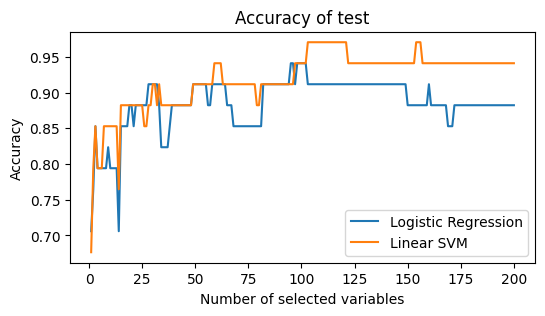

In [27]:
# 로지스틱 회귀 모델과, Linear SVM과의 성능을 시각화하여 비교합니다.
plt.figure(figsize=(6, 3))
plt.plot(feat_num, lr_test_scores, label='Logistic Regression')
plt.plot(feat_num, lsvm_test_scores, label='Linear SVM')
plt.ylabel("Accuracy")
plt.xlabel("Number of selected variables")
plt.title("Accuracy of test")
plt.legend()
plt.show()

## Support Vector Machine 다중 클래스 분류 

Support Vector Machine 분류 모델을 이진 분류만 가능합니다.

이를 다중 분류에 적용하기 위해서는 이진 분류기를 여러 개 만들고, 결과를 종합을 해야 판별 결과를 냅니다. 

### One-vs-One

두 개의 클래스로 짝을 지어 이진 분류 모델을 학습합니다. 이진 분류기는 두 개의 클래스를 뽑는 경우의 수 만큼 생깁니다. ($n(n - 1) / 2$, $n$: 클래스 수). 

학습한 이진 분류기들로 예측하고 가장 많은 분류를 얻은 클래스를 선정합니다. 

동수가 나왔을 경우 분류 마진이 큰 클래스를 선택합니다.

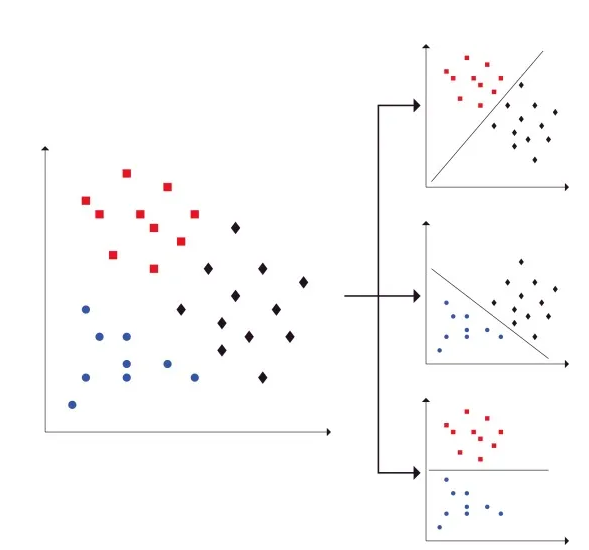


이미지 출처: https://towardsdatascience.com/multi-class-classification-one-vs-all-one-vs-one-94daed32a87b

### One-vs-Rest

하나의 클래스를 선정하여 Positive 클래스, 나머지를 Negative 클래스로 지정하여, 각 클래스를 한 번씩 Positive 클래스하여 이진 분류 모델을 만듭니다. 


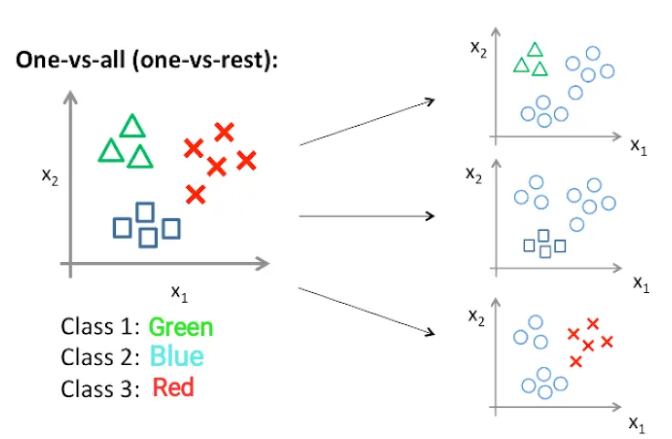

이미지 출처: https://towardsdatascience.com/multi-class-classification-one-vs-all-one-vs-one-94daed32a87b

sklearn.svm.SVC는 one-vs-one 방식으로 구현되어 있습니다.

sklearn.svm.SVC 가이드 발췌
```
The multiclass support is handled according to a one-vs-one scheme.
```

## SVM의 장단점 

### 장점

- 고차원 공간에서 효과적인 분류를 합니다.


- 분류 마진 최대화를 학습의 목표점을 한다는 점은 보다 좋은 일반화 성능을 기대할 수 있는 근거가 됩니다.


- 커널 트릭을 통한 다양한 유형의 비선형 데이터에 대응이 가능합니다.


- 모델의 복잡도를 제어 가능합니다.

### 단점

- 학습시 복잡한 최적화 과정과, 예측시, Kernel 기반의 SVM은 Support Vector에 비례한 연산 자원이 필요하다는 점에서 계산 비용이 높습니다.


- 모델의 해석이 어렵습니다.